In [1]:
import numpy as np
import librosa
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, mesh, load_wav, save_audio, load_pcm
from DistantSpeech.beamformer.MicArray import MicArray


The RT60 is 82 ms
(6, 121515)
(257, 474, 6)
(257, 474, 6)


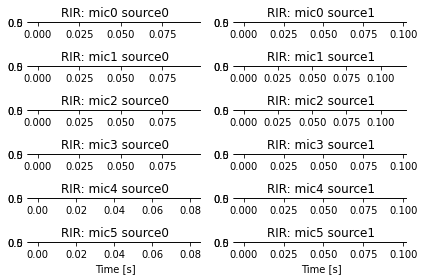

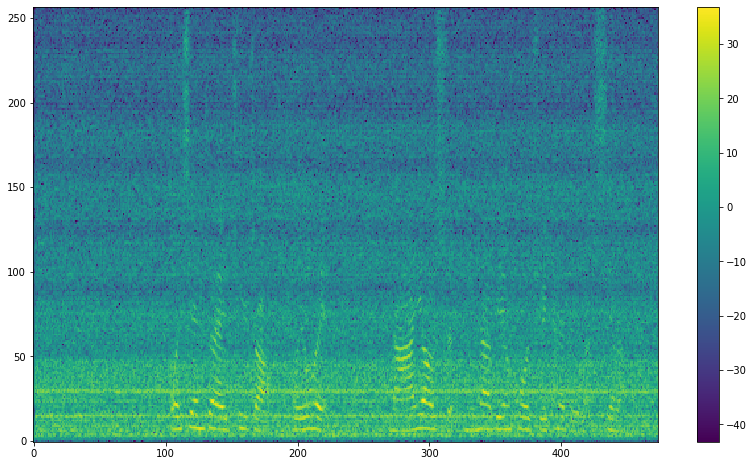

[[ 3.16054062  1.31978371  4.00341854 -7.10324722 -1.36925417]
 [ 3.42044885 -1.14374704  3.19491404 -7.46847717  1.3936401 ]
 [-0.61546125 -0.81355698  1.51038854  0.20329256 -0.43384229]
 [ 0.60106677 -0.06238472 -1.30485516  1.64120809  0.23431773]
 [-4.33313055  0.63761762 -4.35965566  8.38314373  0.62441465]]
[[ 3.00457608  0.95750351  4.00413535 -6.97369931 -0.87977686]
 [ 3.06544067 -5.13299416  3.14391555 -7.25248224  5.49799559]
 [-0.62284869 -0.88069966  1.39784394  0.21782159 -0.30674537]
 [ 0.64508203  0.07585943 -1.29269794  1.60354232  0.05537306]
 [-3.94235173  4.81076073 -4.21332681  8.19059344 -4.57666215]]


In [2]:


sampling_frequency = 16000
fft_length = 512
fft_shift = 256
mic_diameter = 0.1
sound_speed = 343
look_direction = 30

signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550.wav")
# signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office1.wav")
fs = 16000
M = 6
mic_array = MicArray(arrayType="circular", r=mic_diameter/2, M=M)
mic_array_sim = mic_array.array_sim
# print(mic_array_sim.R)
array_data, premix = mic_array_sim.generate_audio(signal, interference=noise, source_angle=look_direction, interf_angle=270, sir=0, snr=30)
print(array_data.shape)
M = array_data.shape[0]
transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))

# array_data = audioread("/home/wangwei/work/DistantSpeech/example/mix.wav")
# src = array_data[:, 0]
# data = array_data[:, 1]
# M = array_data.shape[1]
channels = M
half_bin = 257

# transform = Transform(n_fft=512, hop_length=256, channel=M)
# D = transform.stft(array_data)

n_frames = D.shape[1]
print(D.shape)
Y, _ = transform.magphase(D, 2)
print(D.shape)
pmesh(librosa.power_to_db(Y[:, :, 0]))



a = np.random.rand(5,5)
y = np.random.rand(5,1)
alpha = 0.95
b = alpha*a + (1-alpha)*y@y.T

y1 = np.linalg.inv(a)*y
g = alpha/(1-alpha) + y.T*y1

inversion = np.linalg.inv(b)
print(inversion)
inversion_lemma = 1/alpha*(np.linalg.inv(a)-y1@y1.T/g)
print(inversion_lemma)


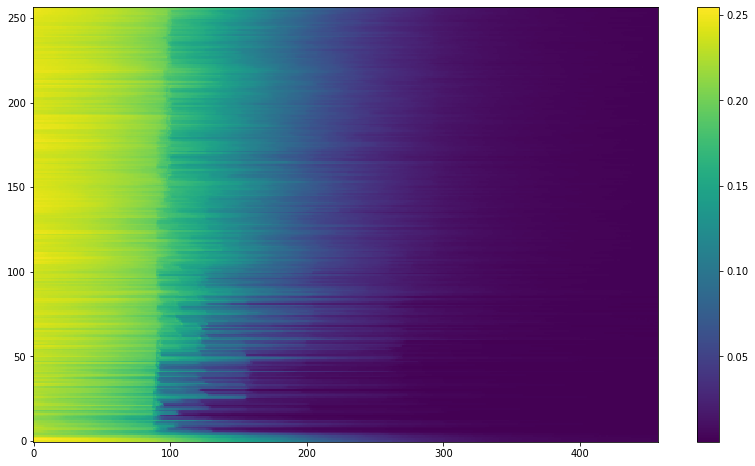

In [3]:
alpha = 0.98
Phi_yy = np.zeros((half_bin, channels, channels), dtype=complex)
Phi_yy_inv = np.zeros((half_bin, channels, channels), dtype=complex)
Phi_yy_inv_th = np.zeros((half_bin, channels, channels), dtype=complex)
delta = 1e-1

for k in range(half_bin):
    Phi_yy[k] = np.eye(M) * delta
    Phi_yy_inv[k] = np.eye(M) / delta

diag_bin = np.broadcast_to(np.eye(M) * 1e-6, (half_bin, M, M))
L = 16
Phi_yy_inv_err = np.zeros((n_frames, half_bin))
# psd_yy = np.einsum('ijk,ijl->ijkl', D.conj(), y)
for n in range(n_frames):
    y = D[:, n, :] #[bin, M]
    psd_yy = np.einsum('ij,il->ijl', y, y.conj())
    # if n == 10:
    #     print('y:\n{}'.format(y[32]))
    #     print('y*y^H\n:{}'.format(y[32:32+1,:].T@y[32:32+1,:].conj()))
    #     print('psd_yy:\n{}'.format(psd_yy[32]))
    y_tilde = Phi_yy_inv@y[:, :, None] # [bin, M, M]@[bin, M, 1]->[bin, M, 1]
    if n<L-1:
        Phi_yy_inv = Phi_yy_inv - y_tilde @ y_tilde.transpose(0, 2,1).conj()/(L + y[:, None, :].conj()@y_tilde)
        Phi_yy = Phi_yy + psd_yy
    elif n == L-1:
        Phi_yy = Phi_yy + psd_yy
        Phi_yy = Phi_yy/L + np.eye(M) * delta
        Phi_yy_inv = Phi_yy_inv - y_tilde @ y_tilde.transpose(0, 2,1).conj()/(L + y[:, None, :].conj()@y_tilde)
    # elif n< L*10:
    #     Phi_yy = alpha * Phi_yy + (1 - alpha) * psd_yy
    #     Phi_yy_inv = np.linalg.inv(Phi_yy+diag_bin)
    else:
        Phi_yy = alpha * Phi_yy + (1 - alpha) * psd_yy
        g = alpha/(1-alpha) + y[:, None, :].conj()@y_tilde
        Phi_yy_inv = 1/alpha*(Phi_yy_inv-y_tilde @ y_tilde.transpose(0, 2,1).conj()/g)

    Phi_yy_inv_th = np.linalg.inv(Phi_yy+diag_bin)
    # Phi_yy_inv_err[n] = np.trace(Phi_yy, axis1=-2, axis2=-1).real
    # Phi_yy_inv_err[n] = librosa.power_to_db(np.trace(Phi_yy_inv_th, axis1=-2, axis2=-1).real)
    Phi_yy_inv_err[n] = librosa.power_to_db(np.trace(Phi_yy_inv, axis1=-2, axis2=-1).real) - librosa.power_to_db(np.trace(Phi_yy_inv_th, axis1=-2, axis2=-1).real)

pmesh((Phi_yy_inv_err[L:].T))


